## H1B Visa Approval Status 
## Mini Project: Logistic Regression and SVMs
## Classification Task

#### Paticia Attah
#### Linda Eliasen


Using logistic regression and SVM we will predict the case status (certified / non certified) of an application submitted by the employer to hire non-immigrant workers under the H-1B visa program. Employers can hire non-immigrant workers only after their LCA petition is certified. The certified LCA petition is then submitted as part of the Petition for a Non-immigrant Worker application for work authorizations for H-1B visa status.<br>

The goal is to uncover insights that can help employers understand the process of getting their LCA approved. The results will help employers understand which applications that they may consider submitting will be certified. This information is important to an employer's buisness operations. It can pinpoint errors or informtion on the appication that may need adjusting to avoid processing delays and also drive the recruiting strategy in denial situations.<br>

Measures of success include accuracy, precision, recall and utltimatley the F Score, which we will compare among models.
The H-1B Dataset contains data from employers Labor Condition Applications and the case certification determinations processed by the Office of Foreign Labor Certification (OFLC) where the date of the determination was issued on or after October 1, 2016 and on or before June 30, 2017.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
import math

import warnings
warnings.filterwarnings("ignore") # ignore warnings for clean report

### Preparing Data
This is the initial dataset that is divided into 3 groups(certified, certified-withdrawn, denied) for logistic regression purposes we reduce this to 2 groups (certified and denied). this data has been cleaned and outliers removed from the previous lab.

<AxesSubplot:title={'center':'count (target)'}>

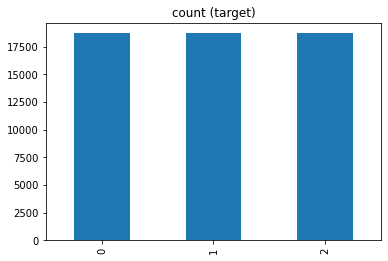

In [2]:
df = pd.read_csv ('Balanced_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [3]:
df1 = df.loc[(df['CASE_STATUS_CODE']==0) | (df['CASE_STATUS_CODE']==2)] 
df1['CASE_STATUS_CODE'] = np.select([df1.CASE_STATUS_CODE==0],[1],0)
np.unique(df1.CASE_STATUS_CODE)

array([0, 1])

<AxesSubplot:title={'center':'count (target)'}>

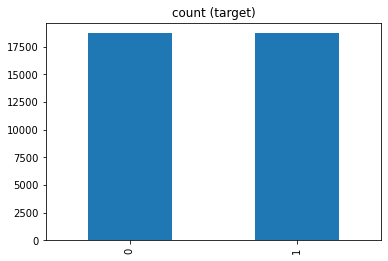

In [4]:
df1['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

## Create Dummmies
At this point we are removing the categorical columns and replacing them with dummy variable that will 0,1 value for the model. Out target variable is 1 which means certified and 0 which specifies denied. In this phase we also removed some unnecesarry varibale incuding the unit of pay and wage unit of pay which specifies how the salary was recorded for an example weekly, bi-weekly monthly.

In [5]:
df2 = df1.drop(['CASE_STATUS','EMPLOYER_NAME_CODE', 'EMPLOYER_CITY_CODE',
           'SOC_NAME_CODE', 'EMPLOYER_STATE_CODE','WILLFUL_VIOLATOR_CODE',
           'AGENT_REPRESENTING_EMPLOYER_CODE', 'JOB_TITLE_CODE', 'EMPLOYER_STATE',
           'WORKSITE_CITY_CODE', 'WORKSITE_STATE_CODE', 'WORKSITE_STATE',
           'PW_UNIT_OF_PAY_CODE', 'PW_WAGE_LEVEL_CODE', 'WAGE_UNIT_OF_PAY_CODE',
           'H1B_DEPENDENT_CODE', 'SUPPORT_H1B_CODE', 'LABOR_CON_AGREE_CODE',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME','PW_UNIT_OF_PAY',
            'EMPLOYER_CITY','WILLFUL_VIOLATOR_CODE', 'WORKSITE_CITY_CODE',
            'SOC_GROUP_Code','SOC_NAME','JOB_TITLE','SOC_GROUP_CODE',
            'WAGE_UNIT_OF_PAY'], axis=1)

In [6]:
WILLFUL_VIOLATOR = pd.get_dummies(df2.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df2 = pd.concat([df2, WILLFUL_VIOLATOR], axis=1)

SOC_GROUP = pd.get_dummies(df2['SOC_GROUP'],drop_first=True)
df2 = pd.concat([df2, SOC_GROUP], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df2.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df2 = pd.concat([df2, PW_WAGE_LEVEL], axis=1)

AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df2.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df2 = pd.concat([df2, AGENT_REPRESENTING_EMPLOYER], axis=1)  

H1B_DEPENDENT = pd.get_dummies(df2.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df2 = pd.concat([df2, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df2.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df2 = pd.concat([df2, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df2.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df2 = pd.concat([df2, SUPPORT_H1B], axis=1)

In [7]:
df2.shape

(37420, 42)

In [8]:
df3 = df2.drop(['WILLFUL_VIOLATOR','PW_WAGE_LEVEL',
               'H1B_DEPENDENT','LABOR_CON_AGREE',
                'AGENT_REPRESENTING_EMPLOYER','SOC_GROUP','SUPPORT_H1B'], axis=1)
df3.head()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,...,Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
12343,1,0,0,0,0,66830.400000,32.130000,66830.400000,32.130000,4,...,0,0,0,0,0,0,0,1,1,0
55773,3,0,0,0,0,59576.065954,59576.065954,59576.065954,59576.065954,4,...,0,0,0,0,0,0,1,1,1,1
51783,1,1,0,0,0,54662.000000,54662.000000,55000.000000,55000.000000,2,...,0,0,0,0,0,0,0,1,1,1
16786,1,0,0,0,0,41018.000000,41018.000000,60000.000000,60000.000000,6,...,0,0,0,0,0,0,0,1,1,1
51681,1,1,0,0,0,54662.000000,54662.000000,55000.000000,55000.000000,4,...,0,0,0,0,0,0,0,1,1,1


In [9]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

In [10]:
pd.set_option('display.max_columns', 100)
df3.shape

(37420, 35)

In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37420 entries, 12343 to 4748
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   TOTAL_WORKERS                                   37420 non-null  int64  
 1   NEW_EMPLOYMENT                                  37420 non-null  int64  
 2   CONTINUED_EMPLOYMENT                            37420 non-null  int64  
 3   CHANGE_PREVIOUS_EMPLOYMENT                      37420 non-null  int64  
 4   NEW_CONCURRENT_EMPLOYMENT                       37420 non-null  int64  
 5   ANNUALIZED_PREVAILING_WAGE                      37420 non-null  float64
 6   PREVAILING_WAGE                                 37420 non-null  float64
 7   ANNUALIZED_WAGE_RATE_OF_PAY                     37420 non-null  float64
 8   WAGE_RATE_OF_PAY                                37420 non-null  float64
 9   DAYS_PROCESS                        

### Test/Train split

In [12]:
# divide data set to x and y and Scale data

y = df3['CASE_STATUS_CODE']
x = df3.drop(['CASE_STATUS_CODE'], axis=1)

In [13]:
a = df3['CASE_STATUS_CODE'].values
bb = df3.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values

x_t = x[:7484]
y_t = y[:7484]

print(x_t.shape)
print(y_t.shape)

(7484, 34)
(7484,)


In [14]:
# create train set
import random
random.seed(0)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(29936,)
(7484, 34)


### Logistic Regression Grid search


In [15]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [16]:
# grid search
params = {
    'penalty':['l2'],        # l1 is Lasso, l2 is Ridge
    'solver':['sag'],
    'C': [0.1,1,10,100]
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(x_train, y_train)

print_results(lr_gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
BEST PARAMS: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

0.591 (+/-0.011) for {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.011) for {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.011) for {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.591 (+/-0.011) for {'C': 100, 'penalty': 'l2', 'solver': 'sag'}


### Logistic Regression Model

Applying a scale it to the entire data before splitting into training and test sets will bias the model evaluation because information would have leaked from the test set to the training set. scikit learn developers recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking: pipe = make_pipeline(StandardScaler(), LogisticRegression()).

In [17]:
# Create pipeline
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('lg', LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1))])
pipe.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('lg',
                 LogisticRegression(C=0.1, random_state=0, solver='sag'))])

### 10fold Cross Validation 

In [18]:
# cross validation
random.seed(10)
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 10
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

In [19]:
# accuracies fom cross validation

#from sklearn.model_selection import cross_val_score
#accuracies = cross_val_score(pipe, x_t, y=y_t, cv=cv_object)
#print(accuracies)

In [20]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
average_accuracy = []
average_precision = []
average_recall = []
average_f1_score=[]
average_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    average_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    average_precision.append(mt.precision_score(a[test_indices],y_hat))
    average_recall.append(mt.recall_score(a[test_indices],y_hat))
    average_f1_score.append(mt.f1_score(a[test_indices],y_hat)) 
    average_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8380545163014431
precision 0.8281769368447968
recall 0.8571050542471553
f1-score 0.8423927178153446
confusion matrix
 [[3033  672]
 [ 540 3239]]
====Iteration 1  ====
accuracy 0.8337787279529664
precision 0.8183908045977012
recall 0.8573722237088574
f1-score 0.8374281233664401
confusion matrix
 [[3036  711]
 [ 533 3204]]
====Iteration 2  ====
accuracy 0.8345804382683057
precision 0.8164251207729468
recall 0.861550845183794
f1-score 0.8383812010443865
confusion matrix
 [[3035  722]
 [ 516 3211]]
====Iteration 3  ====
accuracy 0.832843399251737
precision 0.8125160297512183
recall 0.8590021691973969
f1-score 0.8351126927639383
confusion matrix
 [[3065  731]
 [ 520 3168]]
====Iteration 4  ====
accuracy 0.8297701763762694
precision 0.8171355498721228
recall 0.851092168353756
f1-score 0.8337682672233822
confusion matrix
 [[3015  715]
 [ 559 3195]]
====Iteration 5  ====
accuracy 0.8400587920897915
precision 0.8250319284802043
recall 0.863174772848744
f1-score 

In [21]:
final_accuracy = sum(average_accuracy)/len(average_accuracy)
final_precision = sum(average_precision)/len(average_precision)
final_recall = sum(average_recall)/len(average_recall)
final_f1_score = sum(average_f1_score)/len(average_accuracy)
final_confusion_mat = sum(average_matrix)/len(average_matrix)

print("logistic regression averaged results")
print("average accuracy",final_accuracy)
print("average precision",final_precision)
print("average recall",final_recall)
print("average f1_score",final_f1_score)
print("confusion matrix\n",final_confusion_mat)

logistic regression averaged results
average accuracy 0.8368385889898449
average precision 0.8217228400420433
average recall 0.8607540782744586
average f1_score 0.8407748110689844
confusion matrix
 [[3038.6  699.5]
 [ 521.6 3224.3]]


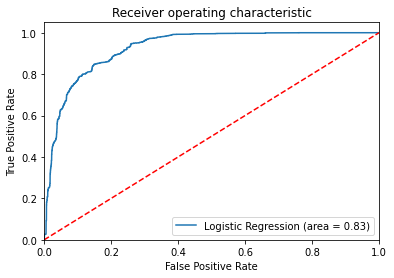

In [22]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, pipe.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Support Vector Machines

In [23]:
# reducing data set size for SVC

df4=df3.sort_values(by=['CASE_STATUS_CODE'])
df4=df4.iloc[13000:, :]
df4=df4.iloc[:11420, :]
df4.shape

(11420, 35)

In [24]:
df4 = df4.sample(frac = 1) 
df4.head(5)

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,CASE_STATUS_CODE,WILL_VIOL_Y,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
13557,1,1,0,0,0,59779.000000,59779.000000,62000.000000,62000.000000,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
48909,1,0,0,0,0,50558.557343,50558.557343,50558.557343,50558.557343,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6331,1,1,0,0,0,64522.000000,64522.000000,64522.000000,64522.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
47694,1,0,0,0,0,69292.293901,69292.293901,69495.216763,69495.216763,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
90,1,1,0,0,0,52312.000000,52312.000000,54000.000000,54000.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0


<AxesSubplot:title={'center':'count (target)'}>

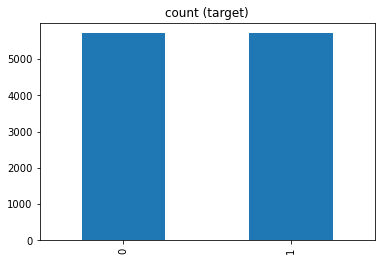

In [25]:
df4['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [26]:
from sklearn import svm

### Test/Train Split for SVM 
The scikit learn SVC model classifier needs a smaller data set to function, due to the requirements of this lab and the capabilities of the scikitlearn model another test train split set has been created this will allow the support vectors to be accessed at the end of the lab.

In [27]:
# Reduced data set preprocessing for SVC
# divide data set to x and y and Scale data
#from sklearn import preprocessing

y = df4['CASE_STATUS_CODE']
x = df4.drop(['CASE_STATUS_CODE'], axis=1)
#x = preprocessing.scale(x) 

a = df4['CASE_STATUS_CODE'].values
bb = df4.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values
#b = preprocessing.scale(b) 

x_t = x[:2284]
y_t = y[:2284]

print(x.shape)
print(y.shape)

(11420, 34)
(11420,)


In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(9136,)
(2284, 34)


In [29]:
# Grid search
svc = GridSearchCV(svm.SVC(gamma='auto',random_state=89),{
            'C':[1,10,100],
                'kernel':['rbf']}, cv=5, verbose=1,)

sv_gs = svc.fit(x_train, y_train)
print_results(sv_gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
BEST PARAMS: {'C': 100, 'kernel': 'rbf'}

0.808 (+/-0.015) for {'C': 1, 'kernel': 'rbf'}
0.808 (+/-0.016) for {'C': 10, 'kernel': 'rbf'}
0.809 (+/-0.014) for {'C': 100, 'kernel': 'rbf'}


In [30]:
# Create pipeline
pipesv = Pipeline([
        ('scale', StandardScaler()),
        ('sv', svm.SVC(C=10,kernel= 'rbf',random_state=89))])
pipesv.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('sv', SVC(C=10, random_state=89))])

In [31]:
iter_num=0
ave_accuracy = []
ave_precision = []
ave_recall = []
ave_f1_score=[]
ave_matrix=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipesv.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipesv.predict(b[test_indices])
    ave_accuracy.append(mt.accuracy_score(a[test_indices],y_hat))
    ave_precision.append(mt.precision_score(a[test_indices],y_hat))
    ave_recall.append(mt.recall_score(a[test_indices],y_hat))
    ave_f1_score.append(mt.f1_score(a[test_indices],y_hat))
    ave_matrix.append(mt.confusion_matrix(a[test_indices],y_hat))
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat)) 
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
#    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8957968476357268
precision 0.8667776852622814
recall 0.9302949061662198
f1-score 0.8974137931034482
confusion matrix
 [[1005  160]
 [  78 1041]]
====Iteration 1  ====
accuracy 0.8830998248686515
precision 0.8609053497942387
recall 0.9143356643356644
f1-score 0.8868164476473082
confusion matrix
 [[ 971  169]
 [  98 1046]]
====Iteration 2  ====
accuracy 0.8962346760070052
precision 0.8647746243739566
recall 0.9324932493249325
f1-score 0.8973581637072325
confusion matrix
 [[1011  162]
 [  75 1036]]
====Iteration 3  ====
accuracy 0.876970227670753
precision 0.8528455284552846
recall 0.9129677980852916
f1-score 0.8818831441782261
confusion matrix
 [[ 954  181]
 [ 100 1049]]
====Iteration 4  ====
accuracy 0.8835376532399299
precision 0.8625514403292182
recall 0.9136878814298169
f1-score 0.8873835732430144
confusion matrix
 [[ 970  167]
 [  99 1048]]
====Iteration 5  ====
accuracy 0.8809106830122592
precision 0.8553259141494436
recall 0.9228130360205832
f1-sco

In [32]:
fin_accuracy = sum(ave_accuracy)/len(ave_accuracy)
fin_precision = sum(ave_precision)/len(ave_precision)
fin_recall = sum(ave_recall)/len(ave_recall)
fin_f1_score = sum(ave_f1_score)/len(ave_accuracy)
fin_confusion_mat = sum(ave_matrix)/len(ave_matrix)

print('SVM averaged results')
print("average accuracy",fin_accuracy)
print("average precision",fin_precision)
print("average recall",fin_recall)
print("average f1_score",fin_f1_score)
print("confusion matrix\n",fin_confusion_mat)

SVM averaged results
average accuracy 0.886646234676007
average precision 0.8593254592468265
average recall 0.9238972980207698
average f1_score 0.8904224994989789
confusion matrix
 [[ 973.7  172.2]
 [  86.7 1051.4]]


In [33]:
scaler = StandardScaler()
for train_indices, test_indices in cv_object.split(b,a):
    X_train = b[train_indices]
    y_train = a[train_indices]
    
    X_test = b[test_indices]
    y_test = a[test_indices]
    
X_train_scaled = scaler.fit_transform(X_train) # apply to training
X_test_scaled = scaler.fit_transform(X_test)

#### Assess how well each model performs
Logistic Regression, (run on the full dataset) had an overall accuracy of 83.6% on the best iteration.   SVM (run on a subset of the data) had an overall accuracy of 88.6% on the best iteration.  The other effectivenss measures are shown below.

Since SVM was run on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data.  

Logistic Regression Model Effectiveness Measures
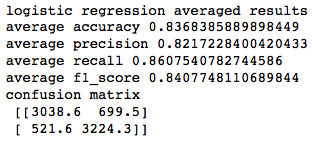
Support Vector Machines Effectiveness Measures
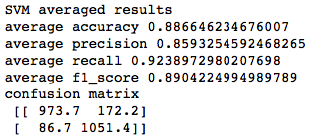

### SECTION 2 - Model Advantages

As stated above, Logistic Regression had an overall accuracy of 83.6% and SVM had an overall accuracy of 88.6%.

We were not able to run SVM on the full dataset.  Since the performance measures are based on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Logistic regression is preferred in cases of a binary outcome (T/F, Y/N) and the objective is to determine if a new sample fits best into a category as it is simpler and more efficient.  Examples of problems where logistic regression is applied include cancer detection (yes/no), test scores (pass/fail), marketing (customer will purchase or not).  

SVM is preferred for unstructured and semi-strutured data like text and images.  It is best when there is an understandable margin of dissociation between classes and is more efficient in high dimensional spaces or when the number of dimensions is larger than the number of specimans.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data.  The model was quick to run and we could interprate the results. We could not do this with the SVM Model. The logistic regression model not only provided a measure of how appropriate a feature was, but also provided the diretion of association so we could interpret the feature importance to the model.  

The downside in using Logistic Regression as opposed to SVM is that Logistic Regression is vulnerable to overfitting because it constructs linear boundaries, so that needs to be taken into account.  Since SVM tries to find the best margin, this reduces that risk.  However, we applied Lasso Regularization to avoid overfitting, so this is not enough of a reason to sway our decision on model appropriateness.  Finally, as we discovered, SVM algorithms are not acceptable for large data sets.

### SECTION 3 Logistic Regression Weight Interpretation

In [34]:
# predictions for logistic regression
pd.set_option('display.max_rows', None)

lg = LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1)
lg.fit(X_train_scaled, y_train)

y_pred = lg.predict(X_test)
coef = lg.coef_

coefs = []
for i in coef[0]:
    coefs.append(round(i,6))

In [35]:
coef = [i for i in coefs]
coef_abs = [abs(i) for i in coefs]
odds = [math.exp(i) for i in coef ]
scale = scaler.scale_
zip_vars = zip(coef,coef_abs,odds,scale,bb.columns) # combine attributes
zip_vars = sorted(zip_vars)

In [36]:
df_weights = pd.DataFrame(zip_vars, columns = ['coef','coef_abs','odds','std_dev','feature_names' ])

In [37]:
# features with highest weights
df_coef = df_weights[df_weights['coef_abs'] > 0.3]
df_coef

,coef,coef_abs,odds,std_dev,feature_names
0,-0.716242,0.716242,0.488585,2.069909,TOTAL_WORKERS
1,-0.634919,0.634919,0.529978,0.141966,Community and Social Service
2,-0.522674,0.522674,0.592933,0.093166,Food Preparation and Serving Related
3,-0.428836,0.428836,0.651267,0.093166,Building and Grounds Cleaning and Maintenance
4,-0.388581,0.388581,0.678018,0.106085,Construction and Extraction
5,-0.384686,0.384686,0.680664,0.062649,Healthcare Support
6,-0.374541,0.374541,0.687605,0.066024,Legal
28,0.329671,0.329671,1.390511,0.346186,SUPPORT_H1B_Y
29,0.425181,0.425181,1.529867,1.207763,NEW_EMPLOYMENT
30,0.472741,0.472741,1.604386,0.421411,CONTINUED_EMPLOYMENT


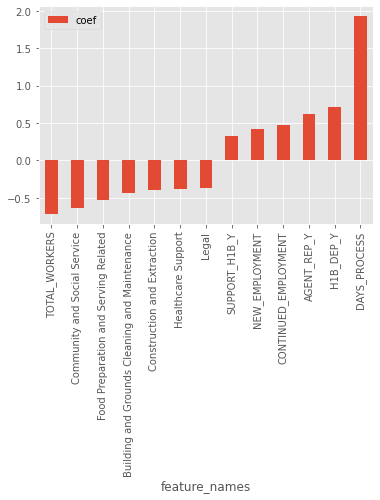

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


ax = df_coef.plot.bar(y='coef', x = 'feature_names')
plt.show()

Interpretation of results

The dependent variable of logistic regression is binary and the “log-odds” of the dependent variable’s probability is modeled by a linear combination of independent variables:
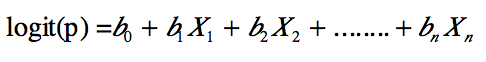
The logit function is defined as the logged odds of probability p:

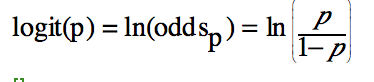
The odds of an event is the probability of it happens over the probability of it doesn’t happen.<br>
The above variables show the features with the highest weights (coefficients), our target variables are certified = 1, denied=0, our model has been validated using cross-validation to check for overfitting.<br>

### Binary Variables
When running the model, the attributes were scaled to have the same dynamic range and are comparable.  For a binary outcome there is an assumption of a linear relationship and we can mathematically describe the influence of each variable on the likelihood of an application being certified with odds ratios by taking the exponent.

Based on magnitude of the coefficient one of the largest  binary coefficient is the SOC_GROUP categorical variable of community and social service which tells us if the person being applied for was for this feild of work. It has a coefficient of -0.6349 which means providing all the other metrics are the same, and flipping the SOC_GROUP from Community and Social Service to NOT Community and Social Service, the log-odds of getting certified will decrease by 0.6349.
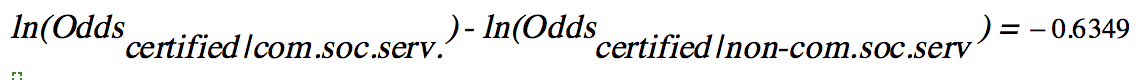

To convert log-odds to odds, we want to take the exponential on both sides of equation which results in the ratio of the odds being 0.5299.
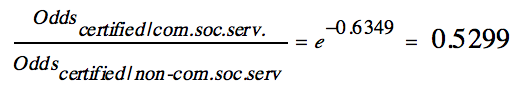
the coefficient of the SOC_GROUP categorical variable community and social service being -0.6349 can be interpreted as the odds of application for an employee in the feild community and social service getting certified over the odds of an applicant that is not in that feild is 0.5299 with all the other variables fixed. In terms of percentage change, the odds community and social service getting certified are 47% lower than the odds for applicant that is not in that feild to get certified this tells us that if if a company wants to appply for such a candidate they may less likely get their candidate certified.

H1B_Dep_Y (0.7093 / 39.05% change in odds of being certified over the campany not being H1B_Dep) also has a larger impact on a negative certification result. This feature denotes that this is an employer who hires ‘too many’ H1B workers. An H1B dependent employer is subject to additional attestation and paperwork requirements when filing for an H1B in an effort to protect U.S. workers. (https://www.visapro.com/resources/article/h1b-dependent-employer/)

Agent_Rep_Y (0.617701 / 85.47% change in odds of being certified over not having legal representation) Meaning that applications that had legal involvement would have improved chances of being certified.

New_Employment This suggests that it is easier to get an application certified if it isa new application vs. an extension under recertification.

From an Occupation Group perspective, those with the most negative impact were Food Preparation/Serving Related, Community/Social Services, Construction and Extraction, & Building Grounds & Construction. This is also reasonable as one of the criteria for certification are specialized occupations.

### Continuous variables (Standardised)

One common pre-processing step when performing logistic regression is to scale the independent variables to the same level (zero mean and unit variance). The motivation of this type of scaling, named standardization, is to make the feature coefficient scales comparable with each other.<br>
<br>To get the standardized coefficients back to odds ratio with interpretable units we convert the standardized unit back to the original unit of the feature. The most prominent continuous variable in our study is DAYS_PROCESS with standard deviation of 1.67 from the table value called std_dev from the scaling algorithm, and the fitted logistic regression gives this feature a standardized coefficient of 1.9421. This means by increasing one standardized unit of DAYS_PROCESS, the odds ratio of getting certified is exp(1.9277) = 6.874 (i.e. the odds of getting certified increase by 587.41%).<br>
<br>From the scaling transformation we know that one standardized unit of age equals to 1.67 days, which is the standard deviation of days before the transformation. Plugging this information back, we can conclude that increasing the DAYS_PROCESS by 1.67 days will lead to an increase of odds of getting certified by 587.41%.

### Other prominent Interpretations

In [39]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
inter = zip(ods,feat,cofs)

for ods,feature,cof in inter:
    od = round((ods*100)-100,2)
    if  cof >0 and feature not in cont_vars:
        print('The odds of',feature,'getting certified over the alternative is', od,'%')

The odds of SUPPORT_H1B_Y getting certified over the alternative is 39.05 %
The odds of NEW_EMPLOYMENT getting certified over the alternative is 52.99 %
The odds of CONTINUED_EMPLOYMENT getting certified over the alternative is 60.44 %
The odds of AGENT_REP_Y getting certified over the alternative is 85.47 %
The odds of H1B_DEP_Y getting certified over the alternative is 103.26 %


In [40]:
feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
scale = list(round(df_coef['std_dev'],4))
inter = zip(ods,feat,cofs,scale)

for ods,feature,cof,scale in inter:
    od = round((ods*100)-100,2)
    if  od >0 and feature in cont_vars:
        print('Increasing the',feature, 'by' ,scale, 'will lead to an increase of odds of getting certified by', od,'%')

Increasing the DAYS_PROCESS by 1.6738 will lead to an increase of odds of getting certified by 587.41 %


## Support Vectors Interpretation

In [41]:
scaler = StandardScaler()
for train_indices, test_indices in cv_object.split(b,a):
    X_train = b[train_indices]
    y_train = a[train_indices]
    
    X_test = b[test_indices]
    y_test = a[test_indices]
    
X_train_scaled = scaler.fit_transform(X_train) # apply to training
X_test_scaled = scaler.fit_transform(X_test)

In [42]:
svmc = svm.SVC(C=100,kernel= 'rbf',random_state=89)
svmc.fit(X_train_scaled, y_train)

SVC(C=100, random_state=89)

In [44]:
# to call the suppport vector foe each variable use the [column index]

svc = svmc.support_vectors_

# look at the support vectors
print(svmc.support_vectors_.shape)
print(svmc.support_.shape)
print(svmc.n_support_ )

(2496, 34)
(2496,)
[1236 1260]


In [45]:
df_test =  df4.iloc[train_indices].copy()
df_support = df_test.iloc[svmc.support_,:].copy()

df_support['CASE_STATUS_CODE'] = a[svmc.support_]

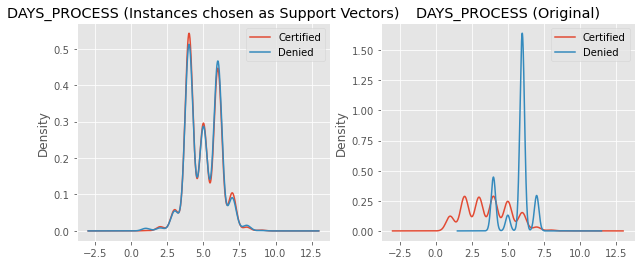

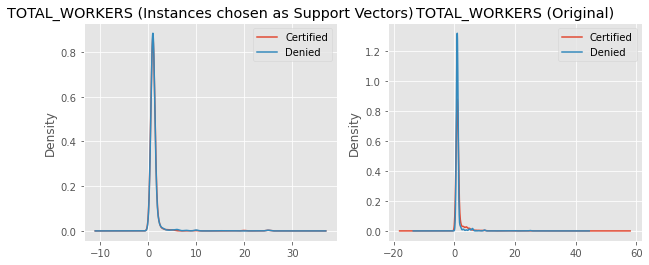

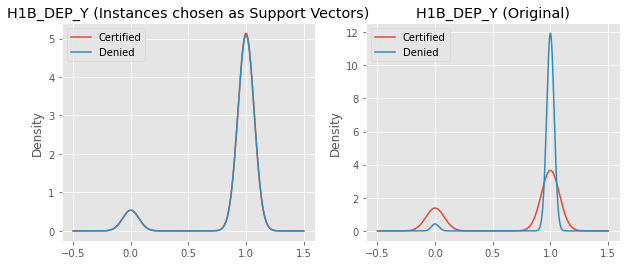

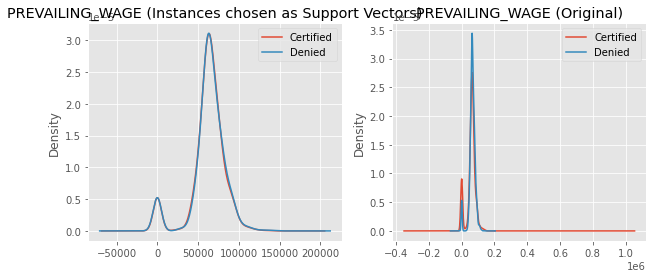

In [46]:
df_grouped_support = df_support.groupby(['CASE_STATUS_CODE'])
df_grouped = df4.groupby(['CASE_STATUS_CODE'])

# plot KDE of Different variables
vars_to_plot = ['DAYS_PROCESS','TOTAL_WORKERS','H1B_DEP_Y','PREVAILING_WAGE']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Certified','Denied'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Certified','Denied'])
    plt.title(v+' (Original)')

The support vector analysis shows the original statistics of these variables as well as the statistics of the support vectors.

Days_Process & H1B_Dep The separation in distribution of the original data is very distinct. This is not the case with the support vectors for the certified class for Days_Process & H1B_Dep. This indicates that they are close to the class boundary resulting in a distribution separation that is not as large and indicates that these cases have been missclassified.

Total_Workers & Prevailing_Wage The support vectors follow the distribution of the original data. However, they do appear to overstate the certified category and did not do well in preserving the orginal data integrity.

#### Exceptional Work
We are requesting consideration for exceptional points as our group is now down to 2 people with the departure of Senthil Kumar

https://medium.com/ro-data-team-blog/interpret-the-impact-size-with-logistic-regression-coefficients-5eec21baaac8


https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16

https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/?ref=rp

https://www.geeksforgeeks.org/support-vector-machine-algorithm/?ref=rp

https://sciphy-stats.com/post/interpreting-logistic-regression-coefficients-odds-ratios/